In [30]:
%matplotlib inline
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import IPython.display
import collections
#import pyfluidsynth

from pathlib import Path
import pretty_midi
import librosa.display
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

%run midi_util.py

folder = 'train/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## midi notes file

In [31]:
"""
d,c = 0,0
fnum = 0
bnum = 0
for f in os.listdir('train/jazz/jazz'):
    print(f)
    try:
        xz = pretty_midi.PrettyMIDI('train/jazz/jazz/'+f)
    except:
        bnum +=1 
        continue
    for i, elt in enumerate(xz.instruments):
        if 'melody' in xz.instruments[i].name.lower():
            d+=1
            print(fnum,d)
    fnum += 1
fnum,bnum, d

(916, 19, 255)  
"""

"\nd,c = 0,0\nfnum = 0\nbnum = 0\nfor f in os.listdir('train/jazz/jazz'):\n    print(f)\n    try:\n        xz = pretty_midi.PrettyMIDI('train/jazz/jazz/'+f)\n    except:\n        bnum +=1 \n        continue\n    for i, elt in enumerate(xz.instruments):\n        if 'melody' in xz.instruments[i].name.lower():\n            d+=1\n            print(fnum,d)\n    fnum += 1\nfnum,bnum, d\n\n(916, 19, 255)  \n"

In [32]:
def getPianoAndMelody(pm, low = 36, high = 84, fs=100):
    def padAndAdd(array1, array2):
        if array1.shape[0] > array2.shape[0]:
            a, b = array1, array2
        else:
            a, b = array2, array1
        ar = np.pad(b, ((0,a.shape[0]-b.shape[0]), (0,0)), 'constant', constant_values=0)
        return a + ar

    maxlen = 0
    pianos = []
    melodies = []
    for i, elt in enumerate(pm.instruments):
        pianoroll = pm.instruments[i].get_piano_roll(fs=fs)[low:high].T
        numnotes = pianoroll.nonzero()[0].shape[0]
        if numnotes > maxlen:
            mostnotes = i
            maxlen = numnotes
        if 'piano' in pm.instruments[i].name.lower():
            pianos.append((pianoroll,numnotes))
        if 'melody' in pm.instruments[i].name.lower():
            melodies.append(pianoroll)
            
    if pianos != {}:
        pianowithmostnotes = max(pianos, key=lambda x: x[1])
        harmonytrack = pianowithmostnotes[0]
    else:
        print("no piano track found so using track with most notes as harmonytrack")
        harmonytrack = pianos[mostnotes][0]
        
    if len(melodies) == 1:
        melodytrack = melodies[0]
    elif len(melodies) == 2:
        print("padding and adding two melodies to one")
        melodytrack = padAndAdd(melodies[0], melodies[1])
    elif len(melodies) > 2:
        print("more than 2 melody tracks. not handled")
        melodytrack = padAndAdd(melodies[0], melodies[1])
    else:
        print("no melody track found.")
        melodytrack = []
        
    return {'melody': melodytrack, 'harmony': harmonytrack}
    

### Decision: Chord Dictionary(>10 chords one hot) & Root note (lowest, 11 one hot)
new decision: chord dict later, first baseline with chords as binary (11 multihot)

## notes list with context chord vector

In [33]:
# highest note is melody
low = 36 # C2=36, C3=48, C4=60, C5=72, C6=84
high = 84 # 48 notes (3 octaves chords, 3 octaves melody (=1 overlap)) (read 2, augment to 3)
pause = 37 # note 37 in representation is pause
maxnotelength = 48

# input sizes
MELODY = 37 # spaeter 36?
TIMES = 48
CHORDS = 36
INPUTSHAPE = MELODY + TIMES + CHORDS*2
INPUTSHAPE

157

In [63]:
def processMidi(pm, low=36, high=84):
    """MIDI to Note list.
    Input: pretty_midi object
    Output: 
        - Notes Array, size: (N,)
        - Times Array, size: (N,)
        - Chords Array, size: (N, 24)
    """
    
    tracks = getPianoAndMelody(pm, low=low, high=high, fs=pm.resolution)
    harmonyroll = tracks['harmony'][:,:24]
    melodyroll = tracks['melody'][:,12:]

    songlength = min(harmonyroll.shape[0],melodyroll.shape[0]) # ERROR maybe need to synchronize start??

    curr_note = pause 
    counter = 0
    beatcounter = 0 # count beat to know what chord notes to collect
    newnote = True
    chords_list, notes_list, times_list = [], [], []
    chordarray = np.zeros(24)
    for i in range(songlength):
        if newnote:
            newnote = False
        nnzidx = melodyroll[i].nonzero()[0]
        if nnzidx.shape[0] > 0:
            new_note = np.max(nnzidx)
        else:
            new_note = pause
        if new_note != curr_note:
            curr_length = int(np.round(counter/10)) # ERROR PRONE | 30->4tel 15-?>8tel 10->12tel?
            #curr_length = counter
            if curr_length > 0:
                notes_list.append(curr_note)
                if curr_length > maxnotelength: # ERROR what about the chord? a well its a pause...
                    times_list.append(maxnotelength)
                else:
                    times_list.append(curr_length)
                chords_list.append(chordarray/counter)
            chordarray = np.zeros(24)
            counter = 1
            curr_note = new_note
            newnote = True
        else:
            counter += 1
            chordidx = harmonyroll[i].nonzero()[0]
            curr_chordarray = np.zeros(24)
            curr_chordarray[chordidx] = 1
            chordarray += curr_chordarray

    notes = np.array(notes_list)
    times = np.array(times_list)
    chords= np.array(chords_list)
    #display(notes.shape, notes.shape == times.shape, notes[:20],times[:20], chords.shape, times)
    return notes, times, chords

def getFeatureVector(notes, times, chords):
    """input size 37+48+36+36 = 157 (mit triolen) 
    Creates Feature Vector from notes lists.
    Input: notes, times, chords from processMIDI
    Output: features array, size: (N,157)
    """
    features = []
    for i, note in enumerate(notes):
        for j in range(12):
            elt = np.zeros(157)
            elt[j+notes[i]] = 1 # melody bit
            offset = MELODY
            elt[offset+times[i]] = 1 # times bit
            # chords
            offset = MELODY + TIMES
            elt[offset+j:offset+j+chords[i].shape[0]] = chords[i]
            if i < len(notes)-1:
                offset = MELODY + TIMES + CHORDS
                elt[offset+j:offset+j+chords[i].shape[0]] = chords[i+1]
                features.append(elt)
    features = np.array(features)
    #display("Features shape:", features.shape)
    return features

def getInputSequences(features, seq_len=16):
    # TODO: add times to label?
    """Create Net Input.
    Input: features from getFeatureVector
    Output: 
        - Sequences, size: (157, seq_len)
        - Labels, one-hot, size: (MELODY,) # TODO: add times to label
    """
    seq_len = seq_len
    sequences = []
    labels = []
    i = 0
    while i+seq_len < features.shape[0]:
        sequences.append(features[i:i+seq_len])
        label = np.argmax(features[i+seq_len,:MELODY])
        labels.append(label)
        #i += seq_len
        i += 1

    sequences = np.array(sequences)
    labels = np.array(labels)
    #display("Sequences.shape, Labels.shape",sequences.shape, labels.shape)
    return sequences, labels


In [64]:
file = 'autumnleaves.mid'
pm = pretty_midi.PrettyMIDI(folder+file)
notes, times, chords = processMidi(pm)
features = getFeatureVector(notes, times, chords)
sequences, labels = getInputSequences(features)

padding and adding two melodies to one


In [36]:
# train/val split
n = 1000
data = sequences[:n]
labels = labels[:n]

perm = np.random.permutation(n)
p = int(0.8*n)

train_data = data[perm[:p]]
train_labels = labels[perm[:p]]
val_data = data[perm[p:]]
val_labels = labels[perm[p:]]

train_data.shape, train_labels.shape

((800, 16, 157), (800,))

In [37]:
counter = collections.Counter(train_labels)
display(counter)
for elt in counter:
    counter[elt] = 1. / counter[elt]
weights  = []
for i in range(MELODY): # error prone
    weights.append(counter.get(i,0))
weights = torch.Tensor(weights)

Counter({18: 24,
         19: 28,
         25: 31,
         26: 29,
         0: 387,
         21: 34,
         27: 28,
         29: 18,
         13: 4,
         24: 31,
         23: 31,
         20: 28,
         22: 29,
         11: 2,
         31: 6,
         16: 15,
         35: 2,
         32: 5,
         14: 7,
         33: 4,
         28: 17,
         17: 12,
         30: 11,
         34: 6,
         15: 8,
         12: 3})

## Load Data for Pytorch

In [38]:
batch_size = 32

class Dataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels, transform=None):
        super(Dataset, self).__init__()
        self.inputs = inputs
        self.labels = labels
        self.transform = transform
       
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        inputs = self.inputs[idx]
        label = self.labels[idx]
        if self.transform: 
            inputs = self.transform(inputs)
        return inputs, label
    

train = Dataset(train_data, train_labels)   
val = Dataset(val_data, val_labels)

#train_weights=weights[train_labels]
#sampler = torch.utils.data.WeightedRandomSampler(weights=train_weights,num_samples=len(train_weights),replacement=True)
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=batch_size, shuffle=False)


## Model

In [39]:
#####################
# Build model
#####################

class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.hidden = self.init_hidden(batch_size)

        self.lstm = nn.LSTM(
            input_size=self.input_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True
        )
        
        self.bn2 = nn.BatchNorm1d(self.hidden_dim)
        
        self.linear = nn.Linear(self.hidden_dim, self.output_dim)

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim))

    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        
        # Only take the output from the final timetep
        fc_input = lstm_out[:,-1,:]
        #fc_input = self.bn2(lstm_out[:,-1,:])
        
        y_pred = self.linear(fc_input)
        # log_probs = F.log_softmax(y_pred,dim=1) # crossentropy is already with softmax
        return y_pred
    
# evaluation
def evaluation(notes=False, loader=val_loader):
    model.eval()
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(loader):
        inputs, labels = inputs.to(device), labels.to(device)

        batch_size = inputs.size(0)
        model.hidden = model.init_hidden(batch_size)

        optim.zero_grad()
        outputs = model(inputs.float())
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if notes and i == 0:
            print(predicted)
    
    acc = int(100 * correct / total)
    model.train()
    return acc

In [40]:
# Model params
input_size = train_data.shape[-1] 
output_dim = MELODY
hidden_size = 64
num_layers = 2

model = LSTM(input_size, hidden_size, output_dim=output_dim, num_layers=num_layers)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

92901

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
loss:  56.4144 acc_train:  48 acc_val:  52
loss:  30.6227 acc_train:  63 acc_val:  61
loss:  16.684 acc_train:  87 acc_val:  77
loss:  11.2805 acc_train:  92 acc_val:  86
loss:  6.8546 acc_train:  95 acc_val:  86
tensor([18, 16, 23, 18, 14,  0,  0,  0, 28, 24, 14, 21,  0, 34, 21, 21, 31,  0,
        13,  0, 23,  0,  0,  0,  0,  0,  0,  0, 27, 21,  0, 26])
tensor([30,  0, 15,  0,  0, 17,  0, 23,  0, 18, 25,  0,  0,  0, 23,  0,  0, 19,
        24,  0,  0, 22,  0,  0,  0, 17, 18,  0,  0,  0,  0,  0])
loss:  4.8104 acc_train:  97 acc_val:  90
loss:  3.161 acc_train:  98 acc_val:  87
loss:  1.9005 acc_train:  99 acc_val:  91
loss:  1.6803 acc_train:  99 acc_val:  89
loss:  0.8833 acc_train:  99 acc_val:  92


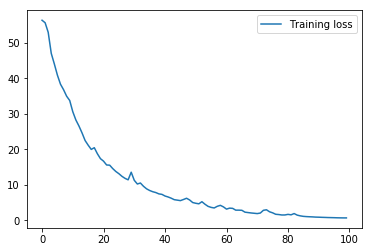

In [48]:
#####################
# Train model
#####################

# Train params
learning_rate = 1e-3
num_epochs = 100
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

#loss_fn = torch.nn.MSELoss()
loss_fn = torch.nn.CrossEntropyLoss()
#loss_fn = torch.nn.NLLLoss(weight=weights, reduction='sum')

hist = np.zeros(num_epochs)

def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)

for t in range(num_epochs):
    loss_curr = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        batch_size = inputs.size(0)
        model.hidden = model.init_hidden(batch_size)
        
        optim.zero_grad()
        outputs = model(inputs.float())
        
        loss = loss_fn(outputs, labels.long())
        
        loss.backward(retain_graph=True)
        #clip_gradient(model, 1e-1)
        optim.step()

        loss_curr = loss_curr + loss.item()
        
    hist[t] = loss_curr
    if t%10==0:
        notes = t%50==0
        acc_train = evaluation(notes, train_loader)
        acc_val = evaluation(notes, val_loader)
        print("loss: ", np.round(hist[t], 4), "acc_train: ", np.round(acc_train,2), "acc_val: ", np.round(acc_val,2))
        
        

#####################
# Plot preds and performance
#####################

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [42]:
train_labels

array([18, 19, 25, 26,  0, 21,  0,  0, 25, 27, 29, 13, 27,  0,  0, 24,  0,
        0, 23, 26,  0,  0, 23,  0,  0, 25, 20, 21, 19, 22,  0, 13, 29, 11,
       21, 24, 20,  0, 31, 16,  0,  0, 25, 35, 32, 29,  0,  0, 16, 22, 29,
        0, 14,  0, 24, 25,  0, 31,  0,  0,  0, 22, 20,  0, 26,  0, 20, 33,
        0, 26,  0,  0,  0, 20, 22,  0, 29, 18,  0,  0, 20, 20, 29, 26, 26,
       24,  0, 35, 26, 27, 22, 28,  0, 22, 21, 22,  0, 20, 33,  0, 28, 19,
       24,  0,  0,  0, 16,  0,  0,  0, 17,  0,  0,  0,  0,  0,  0,  0,  0,
        0, 27, 26,  0,  0,  0, 30, 21,  0,  0, 22, 25,  0,  0, 22, 25,  0,
        0,  0,  0, 21,  0,  0,  0,  0,  0, 23, 25, 21, 14,  0,  0,  0,  0,
       22, 34, 20, 18,  0, 27,  0, 22,  0,  0, 28, 18,  0, 25,  0, 29,  0,
        0,  0,  0, 30, 21,  0,  0,  0,  0, 13,  0, 18, 22, 23,  0,  0, 26,
        0,  0, 21,  0,  0, 22, 19, 15,  0, 21, 25,  0,  0, 23, 25, 24,  0,
        0,  0, 27, 31, 18,  0,  0, 27,  0,  0, 27,  0, 21,  0, 25,  0, 19,
       24,  0, 21, 18,  0

In [235]:
#createMidiFromPianoRoll(y2[:50,:25], low, 'treval', 'realout', tempo=200, threshold=0.1, resolution=8)

# Test Framework

In [1]:
# read test midi file without labels
# output from network
# create midi file with input midi and prediction from network
# simply read midi here to see how it sounds

In [85]:
def getOneHot(arr):
    """
    Input: arr, shape (N,) with values in (0,C) 
    Output: ar, shape (N,24) with one-hot values
    """
    ar = np.zeros((arr.shape[0], int(arr.max()+1)))
    for i in range(arr.shape[0]):
        ar[i, int(arr[i])] = 1
    return ar

def getPredictedNotes(test_loader):
    predicted_notes = np.empty(0)
    model.eval()
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        batch_size = inputs.size(0)
        model.hidden = model.init_hidden(batch_size)

        outputs = model(inputs.float())

        _, predicted = torch.max(outputs.data, 1)
        predicted_notes = np.concatenate((predicted_notes,predicted.detach().numpy()))
    return predicted_notes
    

In [89]:
file = 'test/1_testchord.mid'
testpm = pretty_midi.PrettyMIDI(file)
notes, times, chords = processMidi(testpm)
features = getFeatureVector(notes, times, chords)
test_data, test_labels = getInputSequences(features)
test_dataset = Dataset(test_data, test_labels)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

predicted_notes = getPredictedNotes(test_loader)

#display(np.where(predicted_notes==0), np.where(labels==0) ) #bad

pred = getOneHot(predicted_notes)
    
createMidiFromPianoRoll(pred, low, 'treval', 'netout', tempo=200, threshold=0.1, resolution=8)

pm = pretty_midi.PrettyMIDI('treval/netout.mid')

fs = 44000
IPython.display.Audio(pm.synthesize(fs=44000), rate=44000)

ValueError: max() arg is an empty sequence

# Examples and Visuals

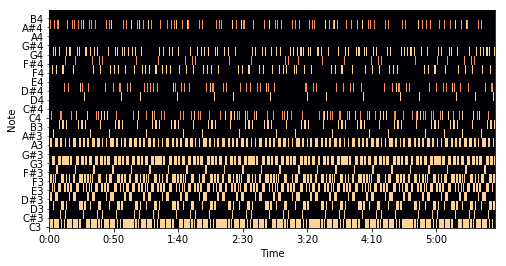

In [10]:
fs = 8
pm = pretty_midi.PrettyMIDI("train/train.mid")
piano_midi = pm.instruments[0] # Get the piano channels
piano_roll = piano_midi.get_piano_roll(fs=fs)
piano_roll = piano_roll[48:72].T

def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

plt.figure(figsize=(8, 4))
plot_piano_roll(pm, 48, 72)

In [7]:
files_dir = "train/"
files_dir = glob.glob("%s*.mid" %(files_dir))
resolution = 8 #ticks per beat

low, high, ticks = getNoteRangeAndTicks(files_dir)
tr = fromMidiCreatePianoRoll(files_dir, ticks, low, high)
#createMidiFromPianoRoll(tr[0], low, "treval/", 'test', tempo=200)

In [8]:
# smallest LSTM example
rnn = nn.LSTM(input_size=10, hidden_size=20, num_layers=2, batch_first=True) # It was batch_first=True!
inputs = torch.randn(5, 300, 10)
hidden = (torch.randn(2, 5, 20), torch.randn(2, 5, 20))
output, hidden = rnn(inputs, hidden)
output.shape

torch.Size([5, 300, 20])

# Train Val Split

In [9]:
def standardize(data):
    """ Move {0,1} data to {-1,1}, then standardize. Standardize data in [0,1]"""
    data = data.astype(np.float32)
    standardized_data = (data - np.mean(data, axis=0)[None,:,:]) / np.std(data, axis=0)[None,:,:]
    return standardized_data

In [11]:
a = standardize(train_data)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [22]:
np.std(train_data, axis=0)

array([[0.        , 0.        , 0.37371718, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.37371718, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.37371718, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [23]:
train_data[0]

array([[ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])